In [2]:
import ee
import geemap
import json
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
ee.Authenticate()
ee.Initialize(project='ee-yuxinchen118')
Map = geemap.Map()

In [4]:
# Define the center coordinates of the study area
center_lat = 31.3304
center_lon = 121.5737

# Conversion constants from kilometers to degrees
km_to_deg_lat = 1 / 111.32
km_to_deg_lon = 1 / (111.32 * math.cos(math.radians(center_lat)))

# Define the extent of the study area in degrees
lat_extent = 40 * km_to_deg_lat
lon_extent = 50 * km_to_deg_lon

# Create the study area as a rectangle geometry
shanghai_region = ee.Geometry.Rectangle([
    center_lon - lon_extent / 2,
    center_lat - lat_extent / 2,
    center_lon + lon_extent / 2,
    center_lat + lat_extent / 2
])

# Define the color scheme and class names
color_scheme = {
    'water': '#419BDF',
    'trees': '#397D49',
    'crops': '#E49635',
    'built': '#C4281B',
    'bare': '#A59B8F'
}

# Define class labels and values
classes = ['water', 'trees', 'crops', 'built', 'bare']
class_values = [0, 1, 2, 3, 4]  # Sequential class values

# Generate color palette from the class names
palette = [color_scheme[cls] for cls in classes]


In [5]:
# Define the desired landcover class order
desired_order = [0, 1, 4, 6, 7]

# Map original landcover values to new class IDs (0 to 4)
value_to_new_class = {original: i for i, original in enumerate(desired_order)}

# Load the CSV file
df = pd.read_csv('Shanghai_Feature_Collection.csv')

# Filter to keep only the desired landcover classes
df = df[df['landcover'].isin(desired_order)]

# Sort rows according to the specified order
df['sort_key'] = df['landcover'].apply(lambda x: desired_order.index(x))
df = df.sort_values(by='sort_key').drop(columns='sort_key')

# Map original landcover values to new class IDs
df['class'] = df['landcover'].map(value_to_new_class)

# Convert to an Earth Engine FeatureCollection
training_features = []
for _, row in df.iterrows():
    geom_dict = json.loads(row['.geo'])
    geometry = ee.Geometry(geom_dict)
    landcover_class = int(row['class'])  # New class ID (0 to 4)
    feature = ee.Feature(geometry, {'class': landcover_class})
    training_features.append(feature)

training_fc = ee.FeatureCollection(training_features)


In [5]:
# Load Sentinel-2 image
image_id = "20220227T023639_20220227T024821_T51RUQ"
sentinel_image = ee.Image("COPERNICUS/S2_SR/" + image_id)

# Select bands suitable for classification
selected_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

# Clip the image to the study area
image = sentinel_image.select(selected_bands).clip(shanghai_region)

# Add commonly used indices as features
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
bsi = image.expression(
    '((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2))', {
        'B11': image.select('B11'),
        'B4': image.select('B4'),
        'B8': image.select('B8'),
        'B2': image.select('B2')
    }
).rename('BSI')

# Merge all selected bands and indices
composite = image.resample('bicubic') \
                 .addBands([ndvi, ndwi, ndbi, bsi])
# Ensure Python list (not EE list) is used to define band names
all_bands = selected_bands + ['NDVI', 'NDWI', 'NDBI', 'BSI']

# Display the original true color image
Map.centerObject(shanghai_region, 10)
Map.addLayer(image.select(['B4', 'B3', 'B2']), 
             {'min': 0, 'max': 3000}, 'Original True Color Image')


In [7]:
# Count number of classes and print sample counts
n_classes = training_fc.aggregate_array('class').distinct().size().getInfo()
for i in range(n_classes):
    count = training_fc.filter(ee.Filter.eq('class', i)).size().getInfo()
    print(f"Class {i} sample count: {count}")

# Split dataset: 70% training, 30% validation
with_random = training_fc.randomColumn('random')
train_fc = with_random.filter(ee.Filter.lt('random', 0.7))
val_fc = with_random.filter(ee.Filter.gte('random', 0.7))
print("Training samples:", train_fc.size().getInfo())
print("Validation samples:", val_fc.size().getInfo())


Class 0 sample count: 33
Class 1 sample count: 30
Class 2 sample count: 25
Class 3 sample count: 77
Class 4 sample count: 31
Training samples: 137
Validation samples: 59


In [8]:
# Sample image using training and validation points
train_data = composite.sampleRegions(collection=train_fc, properties=['class'], scale=10, geometries=True)
val_data = composite.sampleRegions(collection=val_fc, properties=['class'], scale=10, geometries=True)

# Train Random Forest classifier
classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=100, 
    seed=42, 
    minLeafPopulation=10, 
    bagFraction=0.7
).train(features=train_data, classProperty='class', inputProperties=all_bands)

# Apply classifier
classified = composite.classify(classifier)


In [14]:
# Visualize results on map
Map.centerObject(shanghai_region, 10)
Map.addLayer(image.select(['B4', 'B3', 'B2']), {'min': 0, 'max': 3000}, 'True Color')
Map.addLayer(classified, {'min': 0, 'max': n_classes - 1, 'palette': palette}, 'Shanghai RF')

# Add legend
Map.add_legend(title="Land Cover Types", legend_dict={
    'water': '#419BDF', 'trees': '#397D49', 'crops': '#E49635', 
    'built': '#C4281B', 'bare': '#A59B8F'
})

# Display map
display(Map)


Map(bottom=107328.0, center=[31.330553605504914, 121.57370000000014], controls=(WidgetControl(options=['positi…

In [ ]:
import ee
from pathlib import Path

# 初始化 Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-yuxinchen118')  

def export_shanghai_classification(classified):
 

    # 2. 裁剪并转换为整数类型（用于 GeoTIFF 导出）
    classified_clipped = classified.clip(shanghai_region).byte()

    # 3. 创建导出任务
    task = ee.batch.Export.image.toDrive(
        image=classified_clipped,           # ✅ 原始分类图（非可视化）
        description='shanghai_rf_classification_raw',
        folder='psMapresult',       # Drive 文件夹名
        fileNamePrefix='psShanghai_RF_Classification',  # 文件名前缀
        region=shanghai_region,
        scale=30,
        crs='EPSG:4326',
        fileFormat='GeoTIFF',
        maxPixels=1e9
    )

    # 4. 启动任务
    task.start()
    print("✅ 导出任务已启动！请稍候检查 Google Drive 中的 EarthEngine_Exports 文件夹。")
    return task

# ✅ 调用函数
export_task = export_shanghai_classification(classified)

✅ 导出任务已启动！请稍候检查 Google Drive 中的 EarthEngine_Exports 文件夹。


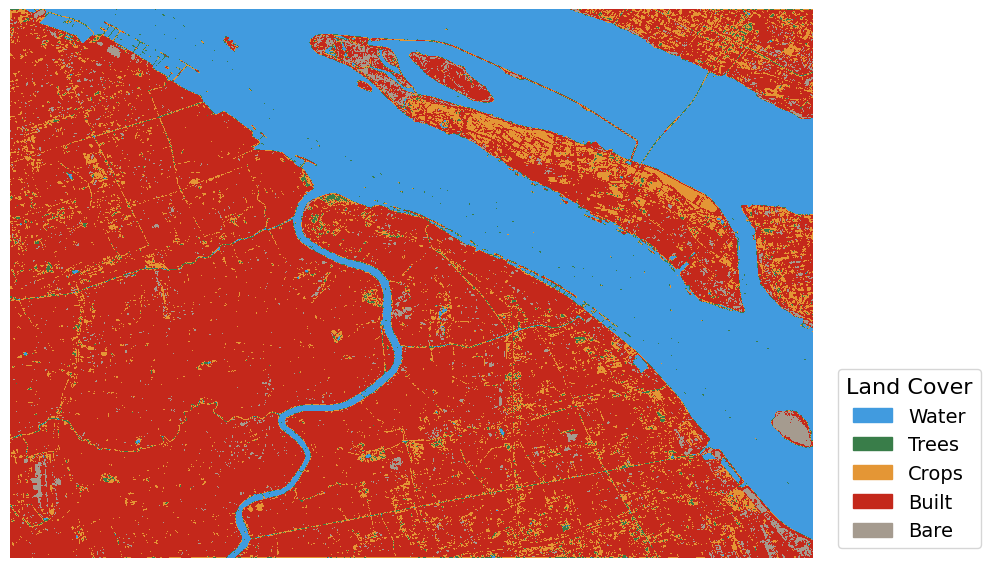

In [9]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# 类别颜色定义
color_scheme = {
    'Water': '#419BDF',
    'Trees': '#397D49',
    'Crops': '#E49635',
    'Built': '#C4281B',
    'Bare': '#A59B8F'
}
palette = list(color_scheme.values())
classes = list(color_scheme.keys())

# 读取 RF 分类 tif
with rasterio.open('psShanghai_RF_Classification.tif') as src:
    rf_image = src.read(1)

# 绘图
plt.figure(figsize=(10, 10))
cmap = plt.matplotlib.colors.ListedColormap(palette)
plt.imshow(rf_image, cmap=cmap, vmin=0, vmax=4)
plt.axis('off')

# 图例右下角外部
legend_patches = [Patch(color=palette[i], label=classes[i]) for i in range(len(classes))]
plt.legend(
    handles=legend_patches,
    title="Land Cover",
    loc='lower left',
    bbox_to_anchor=(1.02, 0),
    frameon=True,
    fontsize=14,
    title_fontsize=16
)

plt.tight_layout()
plt.savefig("Shanghai_RF_Classification_with_Legend.png", dpi=300, bbox_inches='tight')
plt.show()

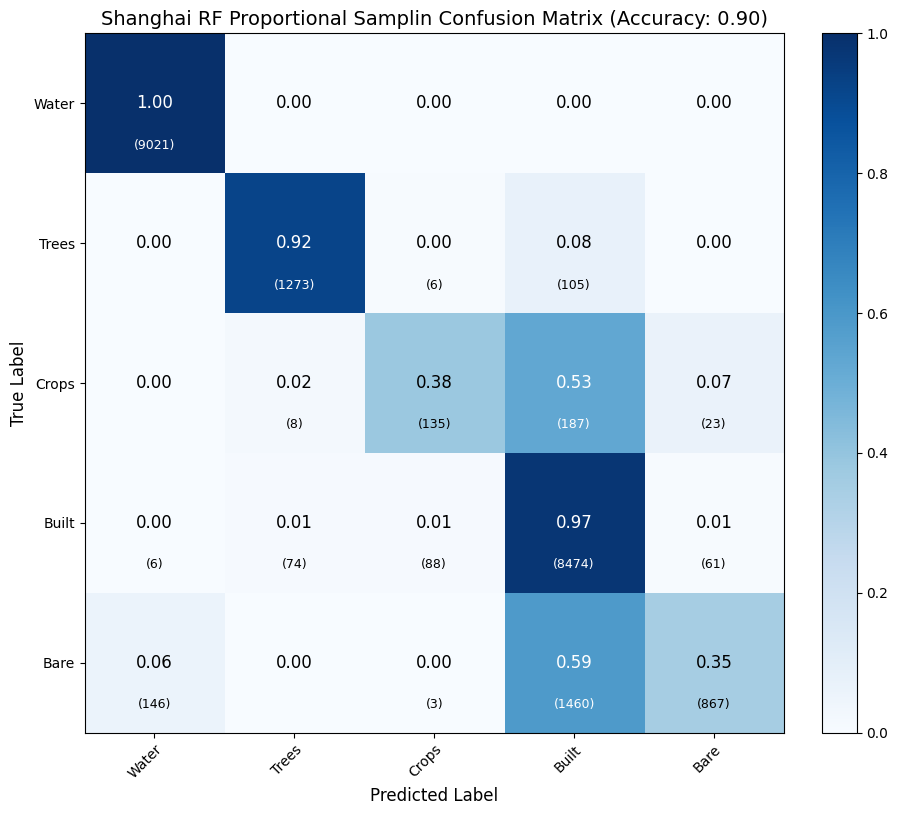

In [8]:
validation = val_data.classify(classifier)
confusion_matrix = validation.errorMatrix('class', 'classification')

def plot_ee_confusion_matrix(confusion_matrix, class_names=None):
    cm_array = np.array(confusion_matrix.array().getInfo())
    accuracy = confusion_matrix.accuracy().getInfo()
    if class_names is None:
        n_classes = cm_array.shape[0]
        class_names = [str(i) for i in range(n_classes)]
    cm_normalized = np.zeros(cm_array.shape)
    for i in range(cm_array.shape[0]):
        row_sum = np.sum(cm_array[i, :])
        if row_sum > 0:
            cm_normalized[i, :] = cm_array[i, :] / row_sum
    
    fig, ax = plt.subplots(figsize=(10, 8))

    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    
    ax.set_title(f'Shanghai RF Proportional Samplin Confusion Matrix (Accuracy: {accuracy:.2f})', fontsize=14)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
   
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            # Show normalized value
            ax.text(j, i, f"{cm_normalized[i, j]:.2f}",
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > 0.5 else "black",
                    fontsize=12)
            
            # Show raw sample count in parentheses
            if cm_array[i, j] > 0:
                ax.text(j, i + 0.3, f"({int(cm_array[i, j])})",
                        ha="center", va="center",
                        color="white" if cm_normalized[i, j] > 0.5 else "black",
                        fontsize=9)
    
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    return fig, ax


class_names = ['Water', 'Trees', 'Crops', 'Built', 'Bare']

fig, ax = plot_ee_confusion_matrix(confusion_matrix, class_names)

plt.show()


In [ ]:
import ee
import geemap
import json
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Define the center coordinates of the study area
center_lat = 31.3304
center_lon = 121.5737

# Conversion constants from kilometers to degrees
km_to_deg_lat = 1 / 111.32
km_to_deg_lon = 1 / (111.32 * math.cos(math.radians(center_lat)))

# Define the extent of the study area in degrees
lat_extent = 40 * km_to_deg_lat
lon_extent = 50 * km_to_deg_lon

# Create the study area as a rectangle geometry
shanghai_region = ee.Geometry.Rectangle([
    center_lon - lon_extent / 2,
    center_lat - lat_extent / 2,
    center_lon + lon_extent / 2,
    center_lat + lat_extent / 2
])


# ========== 加载 Sentinel-2 SR 图像并选择 RGB 波段 ==========
image_id = "20220227T023639_20220227T024821_T51RUQ"
sentinel_image = ee.Image("COPERNICUS/S2_SR/" + image_id).clip(shanghai_region)

rgb_image = sentinel_image.select(['B4', 'B3', 'B2'])  # 红绿蓝

# ========== 下载到本地 ==========
geemap.download_ee_image(
    image=rgb_image,
    filename='shanghai_sentinel2_rgb.tif',
    region=shanghai_region,
    scale=10,
    crs='EPSG:4326'
)

print("✅ Sentinel-2 RGB 图像已成功下载为 'shanghai_sentinel2_rgb.tif'")

shanghai_sentinel2_rgb.tif: |          | 0.00/141M (raw) [  0.0%] in 00:00 (eta:     ?)

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# 打开图像
with rasterio.open('shanghai_sentinel2_rgb.tif') as src:
    img = src.read()  # 3 × H × W
    bounds = src.bounds

    # 获取图像实际长宽比（以 km 为单位）
    lat_range = bounds.top - bounds.bottom
    lon_range = bounds.right - bounds.left
    avg_lat = (bounds.top + bounds.bottom) / 2

    # 转换为公里
    km_per_deg_lat = 111.32
    km_per_deg_lon = 111.32 * math.cos(math.radians(avg_lat))
    lat_km = lat_range * km_per_deg_lat
    lon_km = lon_range * km_per_deg_lon
    aspect_ratio = lon_km / lat_km

# 设置显示大小
height_inches = 8
width_inches = height_inches * aspect_ratio

# 转置为 H × W × 3 并缩放到 0–1 范围（Sentinel-2 原始反射率 × 10000）
img = np.transpose(img, (1, 2, 0))  # H × W × 3
img = np.clip(img / 3000, 0, 1)     # 简单拉伸映射至 0–1（可视化效果较好）

# 绘图
plt.figure(figsize=(width_inches, height_inches), dpi=300)
plt.imshow(img, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.axis('off')
plt.tight_layout()
plt.savefig("Shanghai_Sentinel2_RGB.png", dpi=300, bbox_inches='tight')
plt.show()